In [62]:
'''TODO
Tune hyperparameters with grid search or bayesian optimisation, then do full train and save model weights
Display detailed performance metrics and ensure model is not overfitting
Determine feature importances, and add exogenous features that are likely to be highly correlated (can use tests such as granger causality to assess this)
    Wind Speed: Past wind speeds are highly predictive of future wind production.
    Temperature: Can affect wind patterns and wind production.
    Atmospheric Pressure: Influences wind flow and can be a significant predictor.
    Humidity: Can impact air density and wind speed, affecting wind production.
    Solar Radiation: Can influence thermal gradients, which in turn affect wind patterns
Build a global forecasting model for all regions
Train lightgbm and an svm in the same way
Train meta-model (regularised regression) for stacking on out-of-sample predictions to see if this improves performance
'''

'TODO\nTune hyperparameters with grid search or bayesian optimisation, then do full train and save model weights\nDisplay detailed performance metrics and ensure model is not overfitting\nDetermine feature importances, and add exogenous features that are likely to be highly correlated (can use tests such as granger causality to assess this)\n    Wind Speed: Past wind speeds are highly predictive of future wind production.\n    Temperature: Can affect wind patterns and wind production.\n    Atmospheric Pressure: Influences wind flow and can be a significant predictor.\n    Humidity: Can impact air density and wind speed, affecting wind production.\n    Solar Radiation: Can influence thermal gradients, which in turn affect wind patterns\nBuild a global forecasting model for all regions\nTrain lightgbm and an svm in the same way\nTrain meta-model (regularised regression) for stacking on out-of-sample predictions to see if this improves performance\n'

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from import_dataset import prepare_data
from constants import COUNTRY_CODES
import add_features

In [64]:
#df, df_countries = prepare_data()

from os.path import join
import pandas as pd

def prepare_data() -> tuple:
    
    df = pd.read_csv(join('data', 'TS.CF.N2.30yr.csv'))
    df_country = pd.read_csv(join('data', 'EMHIRESPV_TSh_CF_Country_19862015.csv'))

    # Create hourly DateTime column
    t = pd.date_range('1/1/1986', periods = len(df.index), freq = 'h')

    df['Hour'] = t
    df_country['Hour'] = t

    df = df.set_index('Hour')
    df_country = df_country.set_index('Hour')

    return df, df_country

df, df_country = prepare_data()

In [65]:
print(df.shape)
print(df_country.shape)

(262968, 255)
(262968, 29)


In [66]:
df = add_features.add_calendar_features(df)
df_country = add_features.add_calendar_features(df_country)

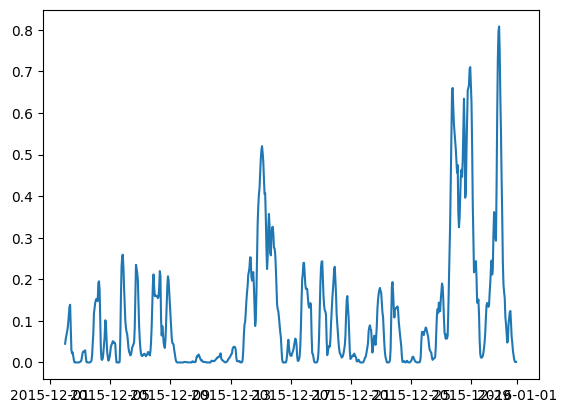

In [67]:
df_last_month = df[-(24*30):]
plt.plot(df_last_month.index, df_last_month['ES24'])

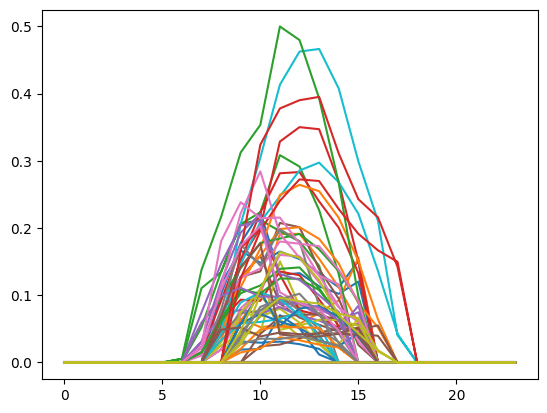

In [68]:
# First day of data
df_first_day_countries = df_country[['Hour'] + COUNTRY_CODES].iloc[:48, :]
df_first_day_countries = df_first_day_countries.set_index('Hour')
plt.plot(df_first_day_countries.index, df_first_day_countries)

In [69]:
# To start with I'll create a simple local model to forecast only the hour-ahead wind energy potential values for Belgium

# Get the last four years of data for belgium
n = 30
df_be_last_n_years = df_country.loc[df_country['Year'].isin(range(2015-n, 2015)), 'BE']

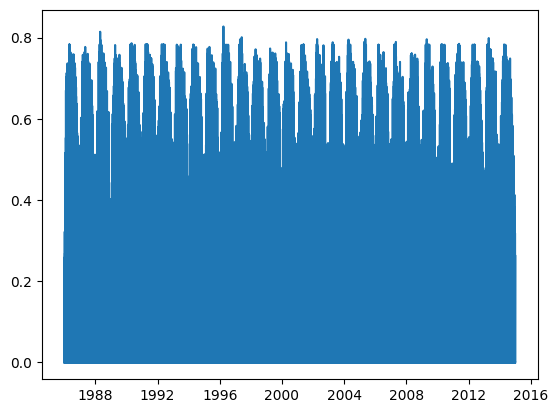

In [70]:
# Plotting the daily data over the two year period suggests there is daily, monthly and annual seasonality
plt.plot(df_be_last_n_years.index, df_be_last_n_years)

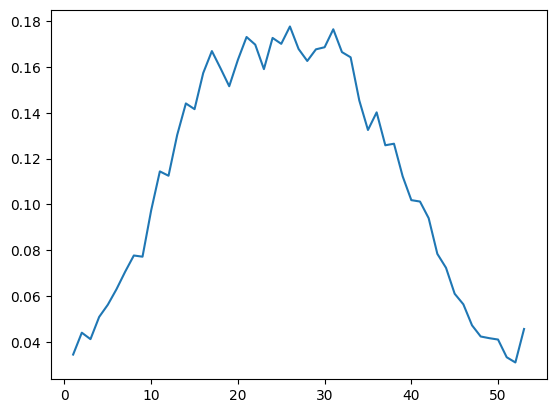

In [71]:
# Plot the weekly totals  for each week of the year over the last four years
df_weekly_totals = df_be_last_n_years.groupby(df_be_last_n_years.index.isocalendar().week).mean()
plt.plot(df_weekly_totals.index, df_weekly_totals)

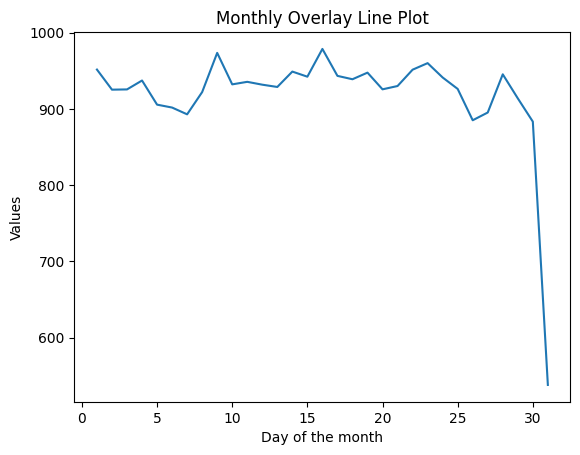

In [72]:
# Let't plot the daily values for each month overlayed to get a clearer picture of monthly seasonality
df_be_last_n_years_daily_tot = df_be_last_n_years.groupby(df_be_last_n_years.index.day).sum()
plt.plot(df_be_last_n_years_daily_tot.index, df_be_last_n_years_daily_tot)
plt.xlabel('Day of the month')
plt.ylabel('Values')
plt.title('Monthly Overlay Line Plot')
plt.show()

In [73]:
# It appears as though the monthly seasonality is less pronounced,
# with the drop on day 31 likely due to the shorter months causing the total to drop

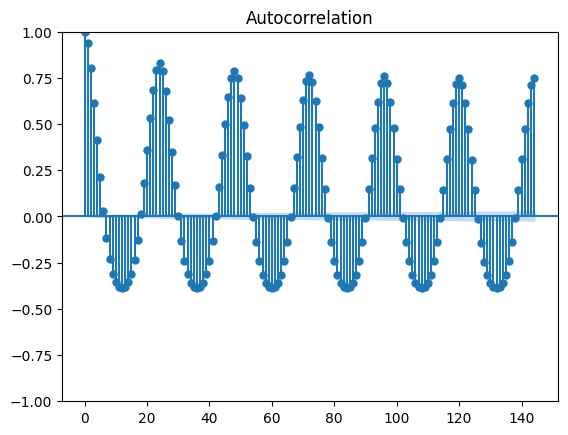

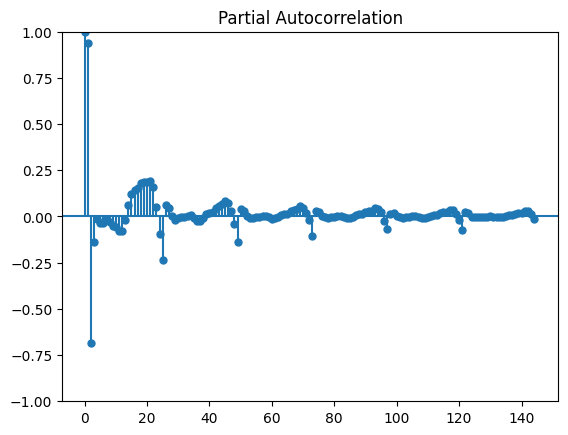

In [74]:
# Calculate the autocorrelation and plot a correlelogram for each hourly lag. This is unlikely to
# give us much useful information as the series is not stationary

# Calculate lag-n autocorrelation
lags = 24 * 7  # Number of hourly lags (for the past week)

'''autocorr_values = [df_be_last_n_years.autocorr(lag=lag) for lag in range(lags)]

print(autocorr_values)

# Create a correlogram
plt.figure(figsize=(8, 6))
plt.stem(range(lags), autocorr_values)#, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Hourly autocorrelation for the Past Week')
plt.grid(True)
plt.show()'''

# Plot ACF
sm.graphics.tsa.plot_acf(df_be_last_n_years.values.squeeze(), lags=48*3)
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_be_last_n_years.values.squeeze(), lags=48*3, method="ywm")
plt.show()


In [75]:
import pandas as pd
import numpy as np

def add_calendar_features(
    df: pd.DataFrame, num_fourier_terms: int = 2, normalise: bool = False
    ) -> pd.DataFrame:
    """
    Adds discrete calendar features (ordinal step functions) and continuous Fourier terms to the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        num_fourier_terms (int): Number of Fourier terms to add (default is 5).
    
    Returns:
        pd.DataFrame: DataFrame with added features.

    Example:
        If num_fourier_terms = 2, this will create sine and cosine wave features with
        wavelengths corresponding to one full cycle per day (i=1), and two full cycles
        per day (i=2).
    """
    
    # Add discrete calendar features (Essentially an ordinal step function)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['DayOfWeek'] = df.index.dayofweek
    df['Hour'] = df.index.hour

    # Add continuous calendar features (Continuous fourier terms)
    for i in range(1, num_fourier_terms + 1):
        freq = 2 * np.pi * i / 24  # Daily frequency (24 hours)
        df[f'Sin_{i}'] = np.sin(freq * df.index.hour)
        df[f'Cos_{i}'] = np.cos(freq * df.index.hour)

    # TODO: Currently returns numpy array instead of df
    #if normalise:
    #    scaler = MinMaxScaler()
    #    df = scaler.fit_transform(df)
    
    return df

def add_time_lags(series: pd.Series, lags: int = 48) -> pd.DataFrame:

    df = pd.DataFrame()
    
    for i in range(1, lags + 1):
        df[f"Lagged_Potential_{i}h"] = series.shift(i)
        
    # Add target back
    df['Wind_Energy_Potential'] = series

    return df

def add_aggregations(df: pd.DataFrame) -> pd.DataFrame:

    # Add rolling window aggregations

    # Add seasonal rolling window aggregations

    # Add exponentially weighted moving averages

    #
    pass

In [76]:
# Time delay embedding

# Prepare the training set by adding lags, other temporal data and eventually some exogeneous featured
# to help the model learn more effectively. It seems like a few days' worth of hourly lags should
# suffice, whilst also keeping the number of features at a manageable level

df = add_time_lags(df_be_last_n_years)
df = add_calendar_features(df, num_fourier_terms=2, normalise=True)


In [77]:
df.tail()

,Lagged_Potential_1h,Lagged_Potential_2h,Lagged_Potential_3h,Lagged_Potential_4h,Lagged_Potential_5h,Lagged_Potential_6h,Lagged_Potential_7h,Lagged_Potential_8h,Lagged_Potential_9h,Lagged_Potential_10h,...,Wind_Energy_Potential,Year,Month,Week,DayOfWeek,Hour,Sin_1,Cos_1,Sin_2,Cos_2
Hour,,,,,,,,,,,,,,,,,,,,,
2014-12-31 19:00:00,0.0,0.0,0.0,0.05743,0.147822,0.226779,0.264344,0.231419,0.192601,0.139667,...,0.0,2014,12,1,2,19,-0.965926,0.258819,-0.500000,-8.660254e-01
2014-12-31 20:00:00,0.0,0.0,0.0,0.00000,0.057430,0.147822,0.226779,0.264344,0.231419,0.192601,...,0.0,2014,12,1,2,20,-0.866025,0.500000,-0.866025,-5.000000e-01
2014-12-31 21:00:00,0.0,0.0,0.0,0.00000,0.000000,0.057430,0.147822,0.226779,0.264344,0.231419,...,0.0,2014,12,1,2,21,-0.707107,0.707107,-1.000000,-4.286264e-16
2014-12-31 22:00:00,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.057430,0.147822,0.226779,0.264344,...,0.0,2014,12,1,2,22,-0.500000,0.866025,-0.866025,5.000000e-01
2014-12-31 23:00:00,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.057430,0.147822,0.226779,...,0.0,2014,12,1,2,23,-0.258819,0.965926,-0.500000,8.660254e-01


In [78]:
# Drop first rows with missing lag values
df = df.dropna()

In [79]:
# Split up the dataset. Just do simple 80:20 split for now

X = df.drop(columns=['Wind_Energy_Potential'])
y = df['Wind_Energy_Potential']

train_size = int(len(y) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.astype(float)
X_test.astype(float)
y_train.astype(float)
y_test.astype(float)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

'''
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train and test model for this split
    ...
'''



(203328, 57)
(50832, 57)
(203328,)
(50832,)


'\n# Create a TimeSeriesSplit object\ntscv = TimeSeriesSplit(n_splits=5)\n\nfor train_index, test_index in tscv.split(X):\n    \n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    \n    # Train and test model for this split\n    ...\n'

In [80]:
'''# train a simple fully-connected neural network
from sklearn.neural_network import MLPRegressor

# the sklearn multilayer perceptron uses mse as the loss function and this can't be changed
reg = MLPRegressor(hidden_layer_sizes=(5, 5, 5), solver='adam', alpha=1e-5, random_state=1)
reg.fit(X_train, y_train)

# After training, you can predict labels for new samples
y_pred = reg.predict(X_test)

# Convert to series with same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

residuals = y_pred - y_test
'''

"# train a simple fully-connected neural network\nfrom sklearn.neural_network import MLPRegressor\n\n# the sklearn multilayer perceptron uses mse as the loss function and this can't be changed\nreg = MLPRegressor(hidden_layer_sizes=(5, 5, 5), solver='adam', alpha=1e-5, random_state=1)\nreg.fit(X_train, y_train)\n\n# After training, you can predict labels for new samples\ny_pred = reg.predict(X_test)\n\n# Convert to series with same index as y_test\ny_pred = pd.Series(y_pred, index=y_test.index)\n\nresiduals = y_pred - y_test\n"

In [81]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Train a simple fully connected nn in pytorch
class FFNN(nn.Module):

    def __init__(
        self,
        input_features: int,
        #hidden_layers: int = 3,
        hidden_connections: int = 5,
        dropout: int = 0.2
        ):
        super(FFNN, self).__init__()
        self.hidden1 = nn.Linear(input_features, hidden_connections)
        self.hidden2 = nn.Linear(hidden_connections, hidden_connections)
        self.hidden3 = nn.Linear(hidden_connections, hidden_connections)
        self.output = nn.Linear(hidden_connections, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Feed input tensor x through the layers
        # Hidden layers use relu, output uses sigmoid activation
        # to constrain the outputs between 0 and 1 which is what
        # we need here
        x = torch.relu(self.hidden1(x))
        x = self.dropout(x)

        x = torch.relu(self.hidden2(x))
        x = self.dropout(x)
        
        x = torch.relu(self.hidden3(x))
        x = self.dropout(x)

        x = torch.sigmoid(self.output(x))

        return x

In [82]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(float).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(float).values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.astype(float).values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(float).values, dtype=torch.float32).view(-1, 1)

# Create data loader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [83]:
# Train the model
def train_model(num_epochs, model, train_loader, test_loader, optimiser, criterion, patience, manual_seed: int = None) -> tuple[np.ndarray, any]:

    if manual_seed:
        # Set the random seed for reproducibility
        torch.manual_seed(manual_seed)
    else:
        torch.manual_seed(torch.initial_seed())
    
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        # Loop through all batches and train model
        for inputs, targets in train_loader:
            optimiser.zero_grad()
            
            # Feed inputs through model
            outputs = model(inputs)
            
            # Calculate loss and update weights
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
        
        # Check for early stopping
        model.eval()
        test_loss = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)

        #print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
        
        early_stopping(test_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # Print out model performance periodically
        if (epoch + 1) % 1 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

    # Make predictions
    model.eval()

    # Turn off gradient tracking for inference (Prevents needless gradient computation, saving memory)
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        
        # Convert tensor back to numpy array
        y_pred = y_pred_tensor.numpy().flatten()
    
    return y_pred

In [ ]:
# Perform a small grid search and save the best hyperparameters
param_grid = {
    'initial_learning_rates': (1e-5, 1e-4, 1e-3),
    'hidden_connections': (5, 6, 7),
    'dropout': (0.2, 0.15, 0.1, 0.05)
}

param_combinations = []

for learning_rate in param_grid['initial_learning_rates']:
    for connections in param_grid['hidden_connections']:
        for dropout in param_grid['dropout']:
                param_combinations.append((connections, dropout, learning_rate))

# Keep num epochs small whilst searching for optimal hyperparams
num_epochs = 10

best_params = ()
best_mse = 0

for params in param_combinations:
    
    connections, dropout, learning_rate = params
    
    # Initialise model, loss function and optimiser with an initial learning rate
    model = FFNN(
        input_features=X_train_tensor.shape[1],
        hidden_connections = connections,
        dropout = dropout
        )

    # Should more harshly penalise poor peak predictions
    criterion = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    
    y_pred = train_model(
        num_epochs=num_epochs,
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        optimiser=optimiser,
        criterion=criterion,
        patience=10
    )

    # Convert predictions to a pandas Series with the same index as y_test
    y_pred = pd.Series(y_pred, index=y_test.index)

    # Calculate out-of-sample mse
    mse = np.mean((y_pred - y_test) ** 2)

    print(f'Test set mse: {mse:.4f}')

    if best_mse == 0 or mse < best_mse:
        best_params = params
        best_mse = mse
        print(f'New best parameters. Connections: {connections}. Dropout: {dropout}. Learning rate: {learning_rate}')

print(best_params)


In [ ]:
# Train the model for more epochs using the best parameters
best_params = (6, 0.1, 1e-05)

connections, dropout, learning_rate = best_params

# Initialise model, loss function and optimiser with an initial learning rate
model = FFNN(
    input_features=X_train_tensor.shape[1],
    hidden_connections = connections,
    dropout = dropout
    )
# Should more harshly penalise poor peak predictions
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

y_pred = train_model(
    num_epochs=100,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimiser=optimiser,
    criterion=criterion,
    patience=10
    )

In [ ]:
# Convert predictions to a pandas Series with the same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

# Calculate residuals
residuals = y_pred - y_test

In [90]:
def plot_actuals_vs_predictions(y_pred: np.ndarray, y_test: np.ndarray) -> None:
    
    # Only want the last 7 days
    end_date = df.index.max()
    start_date = end_date - pd.Timedelta(days=30)

    # Plot the target predictions against the actuals for the test set for the last month
    plt.plot(y_test[start_date:end_date], label='Actuals', color='blue')
    plt.plot(y_pred[start_date:end_date], label='Prediction', color='red')

    plt.xlabel('Time')
    plt.ylabel('Wind Energy Potential')
    plt.title('Actuals vs Predictions')
    plt.legend()

    plt.show()

#plot_actuals_vs_predictions(y_pred, y_test)

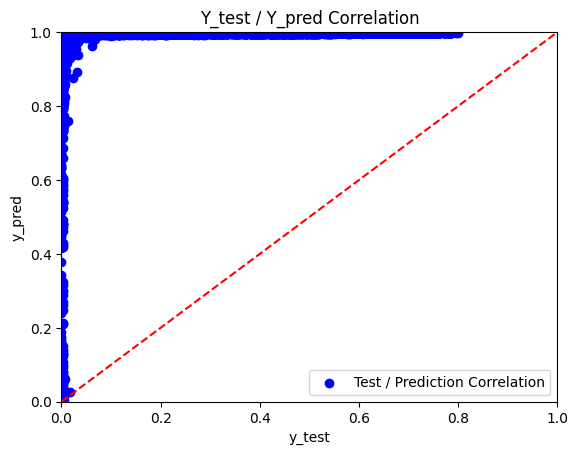

In [86]:
def plot_prediction_actuals_correlation(y_pred: np.ndarray, y_test: np.ndarray) -> None:

    plt.scatter(y_test, y_pred, color='blue', label='Test / Prediction Correlation')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Set axes to start at 0
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Y_test / Y_pred Correlation')
    plt.legend()

plot_prediction_actuals_correlation(y_pred, y_test)

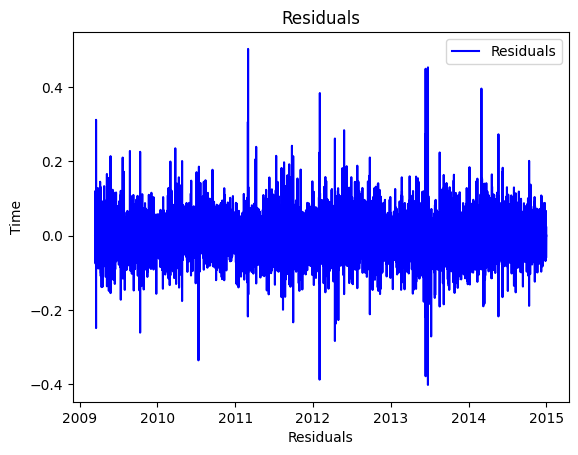

In [104]:
def plot_residuals(residuals: np.ndarray) -> None:
    # Plot the residuals
    # Plot the target predictions against the actuals for the test set for the last month
    plt.plot(residuals, label='Residuals', color='blue')

    plt.xlabel('Residuals')
    plt.ylabel('Time')
    plt.title('Residuals')
    plt.legend()

    plt.show()

plot_residuals(residuals)

In [108]:
# Train a lightgbm model (quicker than xgboost and accepts categorical features without one-hot encoding)
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 1000
bst = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ])

y_pred: np.ndarray = bst.predict(X_test, num_iteration=bst.best_iteration)

# Convert predictions to a pandas Series with the same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

# Calculate residuals
residuals = y_pred - y_test


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12452
[LightGBM] [Info] Number of data points in the train set: 203328, number of used features: 57
[LightGBM] [Info] Start training from score 0.111497
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[289]	valid_0's l2: 0.000659445


In [111]:
import metrics

# Also calculate in-sample predictions for metric calculation
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)

# Display performance metrics and charts
train_mse = metrics.mse(y_train_pred, y_train.values)
test_mse = metrics.mse(y_pred, y_test.values)

bias = metrics.bias(y_train_pred, y_train)
variance = metrics.variance(y_pred)

print(f'Train MSE: {train_mse:.4f}. Test MSE: {test_mse:.4f}')
print(f'Bias: {bias:.4f}. Variance: {variance:.4f}')

plot_actuals_vs_predictions(y_pred, y_test)
plot_prediction_actuals_correlation(y_pred, y_test)
plot_residuals(residuals)

ValueError: operands could not be broadcast together with shapes (203328,) (50832,) 